Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [90]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt


First reload the data we generated in `1_notmnist.ipynb`.

In [91]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [92]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [93]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [17]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    # Input Data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_reg = tf.placeholder(tf.float32)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros(num_labels))

    # Training Computation 
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) \
           + beta_reg * tf.nn.l2_loss(weights)

    # Optimizer 
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


In [26]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        #         print('Initialised')
        for step in range(num_steps):
            offset = (step * batch_size) % \
                     (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:offset + batch_size, :]
            batch_labels = train_labels[offset:offset + batch_size, :]

            feed_dict = {tf_train_dataset: batch_data, \
                         tf_train_labels: batch_labels, beta_reg: regul}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], feed_dict=feed_dict)
        #             if step%500 == 0:
        #                 print("Minibatch loss at step %d: %f" % (step, l))
        #                 print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
        #                 print("Validation accuracy: %.1f%% " % accuracy(valid_prediction.eval(), valid_labels))

        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))


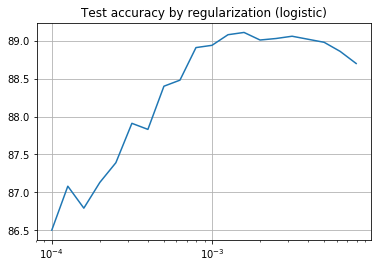

In [27]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

In [39]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=
    (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=
    (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Weights
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta1 = tf.placeholder(tf.float32)
    beta2 = tf.placeholder(tf.float32)

    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) \
           + beta1 * tf.nn.l2_loss(weights1) + beta2 * tf.nn.l2_loss(weights2)

    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [37]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
#         print('Initialised')
        for step in range(num_steps):
            offset = (step * batch_size) % \
                (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]

            feed_dict = {tf_train_dataset:batch_data, \
                         tf_train_labels:batch_labels, beta1 : regul, beta2 : regul}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], feed_dict=feed_dict)
#             if step%500 == 0:
#                 print("Minibatch loss at step %d: %f" % (step, l))
#                 print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
#                 print("Validation accuracy: %.1f%% " % accuracy(valid_prediction.eval(), valid_labels))

        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

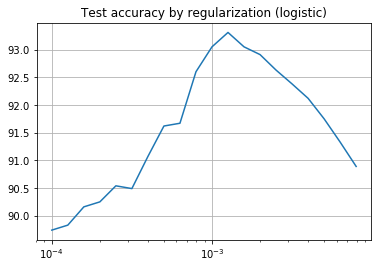

In [38]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [51]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=
                                     (batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=
                                    (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Weights
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta1 = tf.placeholder(tf.float32)
    beta2 = tf.placeholder(tf.float32)
    
    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))\
            + beta1 * tf.nn.l2_loss(weights1) + beta2 * tf.nn.l2_loss(weights2)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [52]:
num_steps = 3001
num_batches = 3
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialised')
    for step in range(num_steps):
        offset = step%num_batches

        batch_data = train_dataset[offset:offset+batch_size, :]
        batch_labels = train_labels[offset:offset+batch_size, :]

        feed_dict = {tf_train_dataset:batch_data, \
                     tf_train_labels:batch_labels, beta1 : regul, beta2 : 1e-3}
        _, l, predictions = session.run([optimizer, loss, \
                                         train_prediction], feed_dict=feed_dict)
        if step%500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%% " % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

#     accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialised
Minibatch loss at step 0: 457.071503
Minibatch accuracy: 6.2% 
Validation accuracy: 28.6% 
Minibatch loss at step 500: 48.271866
Minibatch accuracy: 100.0% 
Validation accuracy: 57.1% 
Minibatch loss at step 1000: 43.682327
Minibatch accuracy: 100.0% 
Validation accuracy: 57.1% 
Minibatch loss at step 1500: 39.801270
Minibatch accuracy: 100.0% 
Validation accuracy: 57.1% 
Minibatch loss at step 2000: 36.433441
Minibatch accuracy: 100.0% 
Validation accuracy: 57.1% 
Minibatch loss at step 2500: 33.454212
Minibatch accuracy: 100.0% 
Validation accuracy: 57.2% 
Minibatch loss at step 3000: 30.782091
Minibatch accuracy: 100.0% 
Validation accuracy: 57.2% 
Test accuracy: 63.0%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [53]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=
    (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=
    (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Weights
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    beta1 = tf.placeholder(tf.float32)
    beta2 = tf.placeholder(tf.float32)

    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) \
           + beta1 * tf.nn.l2_loss(weights1) + beta2 * tf.nn.l2_loss(weights2)

    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [54]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialised')
    for step in range(num_steps):
        offset = (step * batch_size) % \
                (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:offset+batch_size, :]
        batch_labels = train_labels[offset:offset+batch_size, :]

        feed_dict = {tf_train_dataset:batch_data, \
                     tf_train_labels:batch_labels, beta1 : regul, beta2 : regul}
        _, l, predictions = session.run([optimizer, loss, \
                                         train_prediction], feed_dict=feed_dict)
        if step%500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%% " % accuracy(valid_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialised
Minibatch loss at step 0: 565.550659
Minibatch accuracy: 7.8% 
Validation accuracy: 26.8% 
Minibatch loss at step 500: 82.385880
Minibatch accuracy: 75.0% 
Validation accuracy: 80.3% 
Minibatch loss at step 1000: 63.704960
Minibatch accuracy: 71.1% 
Validation accuracy: 79.8% 
Minibatch loss at step 1500: 47.734917
Minibatch accuracy: 82.8% 
Validation accuracy: 79.9% 
Minibatch loss at step 2000: 39.537540
Minibatch accuracy: 81.2% 
Validation accuracy: 80.5% 
Minibatch loss at step 2500: 35.459290
Minibatch accuracy: 73.4% 
Validation accuracy: 80.5% 
Minibatch loss at step 3000: 30.795641
Minibatch accuracy: 78.9% 
Validation accuracy: 80.5% 
Test accuracy: 88.6%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [97]:
batch_size = 128
num_hidden_nodes = [1024, 256, 128]
input_size = [image_size * image_size] + num_hidden_nodes
num_layers = len(num_hidden_nodes)

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=
    (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=
    (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Weights
    weights1 = []
    biases1 = []
    beta1 = []

    for i in range(num_layers):
        weights1.append(tf.Variable(tf.truncated_normal([input_size[i], num_hidden_nodes[i]], \
                                                        stddev=np.sqrt(2.0 / (input_size[i])))))
        biases1.append(tf.Variable(tf.zeros([num_hidden_nodes[i]])))
        beta1.append(1e-3)
    biases2 = tf.Variable(tf.zeros([num_labels]))
    weights2 = tf.Variable(tf.truncated_normal([input_size[-1], num_labels], \
                                               stddev=np.sqrt(2.0 / input_size[-1])))
    beta2 = 1e-3

    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1[0]) + biases1[0])
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    for i in range(1, num_layers):
        print(lay1_train.shape)
        lay1_train = tf.nn.relu(tf.matmul(drop1, weights1[i]) + biases1[i])
        drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) \
           + beta2 * tf.nn.l2_loss(weights2)
    for i in range(num_layers):
        loss += beta1[i] * tf.nn.l2_loss(weights1[i])

        # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions
    train_prediction = tf.nn.softmax(logits)

    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1[0]) + biases1[0])
    for i in range(1, num_layers):
        lay1_valid = tf.nn.relu(tf.matmul(lay1_valid, weights1[i]) + biases1[i])
    logits_valid = tf.matmul(lay1_valid, weights2) + biases2
    valid_prediction = tf.nn.softmax(logits_valid)

    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1[0]) + biases1[0])
    for i in range(1, num_layers):
        lay1_test = tf.nn.relu(tf.matmul(lay1_test, weights1[i]) + biases1[i])
    logits_test = tf.matmul(lay1_test, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)


(128, 1024)
(128, 256)


In [98]:
num_steps = 18001

accuracy_val = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialised')
    for step in range(num_steps):
        offset = (step * batch_size) % \
                 (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:offset + batch_size, :]
        batch_labels = train_labels[offset:offset + batch_size, :]

        feed_dict = {tf_train_dataset: batch_data, \
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, \
                                         train_prediction], feed_dict=feed_dict)
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%% " % accuracy(valid_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialised
Minibatch loss at step 0: 3.871848
Minibatch accuracy: 10.9% 
Validation accuracy: 18.4% 
Minibatch loss at step 500: 1.205388
Minibatch accuracy: 85.9% 
Validation accuracy: 83.8% 
Minibatch loss at step 1000: 1.051275
Minibatch accuracy: 85.2% 
Validation accuracy: 84.2% 
Minibatch loss at step 1500: 0.844605
Minibatch accuracy: 85.2% 
Validation accuracy: 85.5% 
Minibatch loss at step 2000: 0.706294
Minibatch accuracy: 88.3% 
Validation accuracy: 86.3% 
Minibatch loss at step 2500: 0.737942
Minibatch accuracy: 85.9% 
Validation accuracy: 86.9% 
Minibatch loss at step 3000: 0.748825
Minibatch accuracy: 85.2% 
Validation accuracy: 87.0% 
Minibatch loss at step 3500: 0.767259
Minibatch accuracy: 85.2% 
Validation accuracy: 87.7% 
Minibatch loss at step 4000: 0.636193
Minibatch accuracy: 89.8% 
Validation accuracy: 87.6% 
Minibatch loss at step 4500: 0.660385
Minibatch accuracy: 89.1% 
Validation accuracy: 87.9% 
Minibatch loss at step 5000: 0.609464
Minibatch accuracy: 88.3